12.990949
557.7679
54.853268
1627.1544
[['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ...
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']]
5


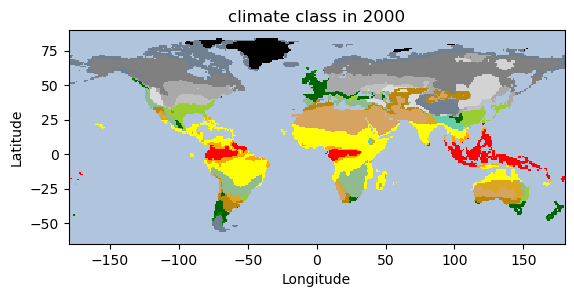

In [7]:
import numpy as np
import netCDF4 as nc
from calendar import monthrange
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from collections import Counter, OrderedDict
# Open the netCDF file (retrieve temperature data)

years = [900, 1400, 1700, 1850, 1950, 2000]

for year in years:
    if year==900:
        tas_data = np.load('/work/a06/tsuda/m1/mean_tas_900.npy')
        tas_data = np.roll(tas_data, shift=180, axis=2)
        tas_data = np.flip(tas_data,axis=1)
        
        # Open the netCDF file (retrieve precipitation data)
        pr_data = np.load('/work/a06/tsuda/m1/mean_pr_900.npy')
        pr_data = np.roll(pr_data, shift=180, axis=2)
        pr_data = np.flip(pr_data,axis=1)
        
        MAT = np.mean(tas_data, axis=0)
        print(MAT[55,315])
        Tcold = np.min(tas_data, axis=0)
        Thot = np.max(tas_data, axis=0)
        Tmon10 = np.zeros((180, 360))
        AS_tas_data = np.zeros((180, 360))
        for i in range(180):
            for j in range(360):
                Tmon10[i, j] = np.count_nonzero(tas_data[:, i, j] > 10)

        MAP = np.sum(pr_data, axis=0)
        Pdry = np.min(pr_data, axis=0)
        
        # Separate data for summer (April-September) and winter (October-March)
        AS_tas_data = tas_data[3:9]
        AS_pr_data = pr_data[3:9]
        OM_tas_data = np.concatenate([tas_data[0:3], tas_data[9:12]], axis=0)
        OM_pr_data = np.concatenate([pr_data[0:3], pr_data[9:12]], axis=0)

        AS_tas_avg = np.mean(AS_tas_data)
        OM_tas_avg = np.mean(OM_tas_data)

        # Corrected the if condition
        if AS_tas_avg > OM_tas_avg:
            S_tas_data = AS_tas_data
            W_tas_data = OM_tas_data
        else:
            S_tas_data = OM_tas_data
            W_tas_data = AS_tas_data

        AS_pr_avg = np.mean(AS_pr_data)
        OM_pr_avg = np.mean(OM_pr_data)

        if AS_pr_avg > OM_pr_avg:
            S_pr_data = AS_pr_data
            W_pr_data = OM_pr_data
        else:
            S_pr_data = OM_pr_data
            W_pr_data = AS_pr_data

        Psdry = np.min(S_pr_data, axis=0)
        Pwdry = np.min(W_pr_data, axis=0)
        Pswet = np.max(S_pr_data, axis=0)
        Pwwet = np.max(W_pr_data, axis=0)
        Pthreshold = np.zeros((180, 360))
# Corrected the indentation and added missing colon

        for i in range(180):
            for j in range(360):
                if np.sum(W_pr_data[:,i,j]) > np.sum(pr_data[:,i,j]) * 0.7:
                    Pthreshold[i,j] = 2 * MAT[i,j]
                elif np.sum(S_pr_data[:,i,j]) > np.sum(pr_data[:,i,j]) * 0.7:
                    Pthreshold[i,j] = 2 * MAT[i,j] + 28
                else:
                    Pthreshold[i,j] = 2 * MAT[i,j]+ 14
        print(np.sum(W_pr_data[:,105,315]))
        print(np.sum(S_pr_data[:,105,315]))
        print(np.sum(pr_data[:,55,315]))

        climate_class = np.full((180, 360), '', dtype='U3')
        # �����Ɋ�Â���climate_class��ݒ�

        for i in range(180):
            for j in range(360):
                if Tcold[i, j] >= 18:
                    if Pdry[i, j] >= 60:
                        climate_class[i, j] = 'Af'
                    elif Pdry[i, j] >= 100 - MAP[i, j] / 25:
                        climate_class[i, j] = 'Am'
                    else:
                        climate_class[i, j] = 'Aw'
                elif MAP[i, j] < 10 * Pthreshold[i, j]:
                    if MAP[i, j] < 5 * Pthreshold[i, j]:
                        climate_class[i, j] = 'BW'
                    elif MAT[i, j] >= 18:
                        climate_class[i, j] = 'BSh'
                    else:
                        climate_class[i, j] = 'BSk'
                elif 0 < Tcold[i, j] < 18 and Thot[i, j] > 10:
                    if Psdry[i, j] < 40 and Psdry[i, j] < Pwwet[i, j] / 3:
                        climate_class[i, j] = 'Cs'
                    elif Pwdry[i, j] < Pswet[i, j] / 10:
                        climate_class[i, j] = 'Cw'
                    elif Thot[i, j] >= 22:
                        climate_class[i, j] = 'Cfa'
                    elif Tmon10[i, j] >= 4:
                        climate_class[i, j] = 'Cfb'
                    elif 1 <= Tmon10[i, j] < 4:
                        climate_class[i, j] = 'Cfc'
                elif MAP[i, j] >= 10 * Pthreshold[i, j] and Thot[i, j] > 10 and Tcold[i, j] <= 0:
                    if Psdry[i, j] < 40 and Psdry[i, j] < Pwwet[i, j] / 3:
                        climate_class[i, j] = 'Ds'
                    elif Pwdry[i, j] < Pswet[i, j] / 10:
                        climate_class[i, j] = 'Dw'
                    elif Thot[i, j] >= 22:
                        climate_class[i, j] = 'Dfa'
                    elif Tmon10[i, j] >= 4:
                        climate_class[i, j] = 'Dfb'
                    elif Tcold[i, j] < -38:
                        climate_class[i, j] = 'Dfd'
                    else:
                        climate_class[i, j] = 'Dfc'
                elif Thot[i, j] > 0:
                    climate_class[i, j] = 'ET'
                else:
                    climate_class[i, j] = 'EF'

        new_population_data = np.load('new_population_180360_2000.npy')
        # Set climate_class to 'nan' where new_population_data is less than 0
        for i in range(180):
            for j in range(360):
                if new_population_data[i, j] < 0:
                    climate_class[i, j] = np.nan

        # Print the modified climate_class
        print(climate_class)
        # Create a color map for different climate classes


        # Create a color map for different climate classes
        class_colors = OrderedDict({
            'Af': (255/255, 0/255, 0/255),
            'Am': (255/255, 165/255, 0/255),
            'Aw': (255/255, 255/255, 0/255),
            'BW': (214/255, 164/255, 96/255),
            'BSh': (218/255, 165/255, 32/255),
            'BSk': (184/255, 134/255, 11/255),
            'Cs': (143/255, 188/255, 143/255),
            'Cw': (102/255, 205/255, 170/255),
            'Cfa': (154/255, 205/255, 50/255),
            'Cfb': (0/255, 100/255, 0/255),
            'Cfc': (0/255, 128/255, 0/255),
            'Ds': (220/255, 220/255, 220/255),
            'Dw': (211/255, 211/255, 211/255),
            'Dfa': (192/255, 192/255, 192/255),
            'Dfb': (169/255, 169/255, 169/255),
            'Dfc': (128/255, 128/255, 128/255),
            'Dfd': (169/255, 169/255, 169/255),
            'ET': (112/255, 128/255, 144/255),
            'EF': (0/255, 0/255, 0/255)
        })


        # Create an array to store colors for each grid cell based on climate class
        color_array = np.zeros((180, 360, 3), dtype=np.uint8)

        # Define a color for 'nan' values
        nan_color = [176, 196, 222]  # You can change this color as needed

        # Assign colors to each grid cell based on climate class
        for i in range(180):
            for j in range(360):
                current_class = climate_class[i, j]
                if current_class != 'nan':
                    color_array[i, j] = np.multiply(255, to_rgba(class_colors[current_class])[:3])
                else:
                    color_array[i, j] = nan_color
        # Extract latitude and longitude information
        latitudes = np.linspace(90, -90, 180)
        longitudes = np.linspace(-180, 180, 360)



        # Display the color map with latitude and longitude information
        plt.imshow(color_array, interpolation='none', extent=[-180, 180, -90, 90])  # Include latitude and longitude information
        plt.title('Climate Class in 2000')  # Set title
        plt.xlabel('Longitude')  # Set xlabel
        plt.ylabel('Latitude')  # Set ylabel
        plt.ylim(-65,90)

        # Create legend
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=key, 
                                    markerfacecolor=class_colors[key], markersize=10)
                        for key in class_colors.keys()]
        plt.title('climate class in 2000')
        #plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
        #plt.show()
        # Show the plot
        plt.savefig(f'new_climate_class_2000.png', bbox_inches='tight')
        np.save(f'new_climate_class_2000.npy', climate_class)
        print(5)

        


In [2]:
import numpy as np

pop_count_data = np.genfromtxt("/work/a06/tsuda/grid_transition/climate_class/popc_2000AD.asc", skip_header=6, delimiter='')
new_population_data = np.zeros((180, 360))

for p in range(180):
    for k in range(360):
        grid_slice = pop_count_data[p * 12:(p + 1) * 12, k * 12:(k + 1) * 12]

        total_population = np.sum(grid_slice[grid_slice >= 0])
        num_nonzero_cells = np.sum(grid_slice >= 0)
        if num_nonzero_cells > 0:
            new_population_data[p, k] = total_population
        else:
            new_population_data[p, k] = -500
np.save(f'new_population_180360_2000.npy', new_population_data)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from collections import OrderedDict

years = [900, 1400, 1700, 1850, 1950, 2000]

for year in years:
    # データの読み込み
    tas_data = np.load(f'/work/a06/tsuda/m1/mean_tas_{year}.npy')
    tas_data = np.roll(tas_data, shift=180, axis=2)
    tas_data = np.flip(tas_data, axis=1)
    pr_data = np.load(f'/work/a06/tsuda/m1/mean_pr_{year}.npy')
    pr_data = np.roll(pr_data, shift=180, axis=2)
    pr_data = np.flip(pr_data, axis=1)

    # ここに気候分類の計算ロジックを挿入（上記のコードを参照）
    MAT = np.mean(tas_data, axis=0)
    print(MAT[55,315])
    Tcold = np.min(tas_data, axis=0)
    Thot = np.max(tas_data, axis=0)
    Tmon10 = np.zeros((180, 360))
    AS_tas_data = np.zeros((180, 360))
    for i in range(180):
        for j in range(360):
            Tmon10[i, j] = np.count_nonzero(tas_data[:, i, j] > 10)

    MAP = np.sum(pr_data, axis=0)
    Pdry = np.min(pr_data, axis=0)
    
    # Separate data for summer (April-September) and winter (October-March)
    AS_tas_data = tas_data[3:9]
    AS_pr_data = pr_data[3:9]
    OM_tas_data = np.concatenate([tas_data[0:3], tas_data[9:12]], axis=0)
    OM_pr_data = np.concatenate([pr_data[0:3], pr_data[9:12]], axis=0)

    AS_tas_avg = np.mean(AS_tas_data)
    OM_tas_avg = np.mean(OM_tas_data)

    # Corrected the if condition
    if AS_tas_avg > OM_tas_avg:
        S_tas_data = AS_tas_data
        W_tas_data = OM_tas_data
    else:
        S_tas_data = OM_tas_data
        W_tas_data = AS_tas_data

    AS_pr_avg = np.mean(AS_pr_data)
    OM_pr_avg = np.mean(OM_pr_data)

    if AS_pr_avg > OM_pr_avg:
        S_pr_data = AS_pr_data
        W_pr_data = OM_pr_data
    else:
        S_pr_data = OM_pr_data
        W_pr_data = AS_pr_data

    Psdry = np.min(S_pr_data, axis=0)
    Pwdry = np.min(W_pr_data, axis=0)
    Pswet = np.max(S_pr_data, axis=0)
    Pwwet = np.max(W_pr_data, axis=0)
    Pthreshold = np.zeros((180, 360))
# Corrected the indentation and added missing colon

    for i in range(180):
        for j in range(360):
            if np.sum(W_pr_data[:,i,j]) > np.sum(pr_data[:,i,j]) * 0.7:
                Pthreshold[i,j] = 2 * MAT[i,j]
            elif np.sum(S_pr_data[:,i,j]) > np.sum(pr_data[:,i,j]) * 0.7:
                Pthreshold[i,j] = 2 * MAT[i,j] + 28
            else:
                Pthreshold[i,j] = 2 * MAT[i,j]+ 14
    print(np.sum(W_pr_data[:,105,315]))
    print(np.sum(S_pr_data[:,105,315]))
    print(np.sum(pr_data[:,55,315]))

    climate_class = np.full((180, 360), '', dtype='U3')
    # �����Ɋ�Â���climate_class��ݒ�

    for i in range(180):
        for j in range(360):
            if Tcold[i, j] >= 18:
                if Pdry[i, j] >= 60:
                    climate_class[i, j] = 'Af'
                elif Pdry[i, j] >= 100 - MAP[i, j] / 25:
                    climate_class[i, j] = 'Am'
                else:
                    climate_class[i, j] = 'Aw'
            elif MAP[i, j] < 10 * Pthreshold[i, j]:
                if MAP[i, j] < 5 * Pthreshold[i, j]:
                    climate_class[i, j] = 'BW'
                elif MAT[i, j] >= 18:
                    climate_class[i, j] = 'BSh'
                else:
                    climate_class[i, j] = 'BSk'
            elif 0 < Tcold[i, j] < 18 and Thot[i, j] > 10:
                if Psdry[i, j] < 40 and Psdry[i, j] < Pwwet[i, j] / 3:
                    climate_class[i, j] = 'Cs'
                elif Pwdry[i, j] < Pswet[i, j] / 10:
                    climate_class[i, j] = 'Cw'
                elif Thot[i, j] >= 22:
                    climate_class[i, j] = 'Cfa'
                elif Tmon10[i, j] >= 4:
                    climate_class[i, j] = 'Cfb'
                elif 1 <= Tmon10[i, j] < 4:
                    climate_class[i, j] = 'Cfc'
            elif MAP[i, j] >= 10 * Pthreshold[i, j] and Thot[i, j] > 10 and Tcold[i, j] <= 0:
                if Psdry[i, j] < 40 and Psdry[i, j] < Pwwet[i, j] / 3:
                    climate_class[i, j] = 'Ds'
                elif Pwdry[i, j] < Pswet[i, j] / 10:
                    climate_class[i, j] = 'Dw'
                elif Thot[i, j] >= 22:
                    climate_class[i, j] = 'Dfa'
                elif Tmon10[i, j] >= 4:
                    climate_class[i, j] = 'Dfb'
                elif Tcold[i, j] < -38:
                    climate_class[i, j] = 'Dfd'
                else:
                    climate_class[i, j] = 'Dfc'
            elif Thot[i, j] > 0:
                climate_class[i, j] = 'ET'
            else:
                climate_class[i, j] = 'EF'

    new_population_data = np.load('new_population_180360_2000.npy')
    # Set climate_class to 'nan' where new_population_data is less than 0
    for i in range(180):
        for j in range(360):
            if new_population_data[i, j] < 0:
                climate_class[i, j] = np.nan

    # Print the modified climate_class
    print(climate_class)
    # Create a color map for different climate classes


    # Create a color map for different climate classes
    class_colors = OrderedDict({
        'Af': (255/255, 0/255, 0/255),
        'Am': (255/255, 165/255, 0/255),
        'Aw': (255/255, 255/255, 0/255),
        'BW': (214/255, 164/255, 96/255),
        'BSh': (218/255, 165/255, 32/255),
        'BSk': (184/255, 134/255, 11/255),
        'Cs': (143/255, 188/255, 143/255),
        'Cw': (102/255, 205/255, 170/255),
        'Cfa': (154/255, 205/255, 50/255),
        'Cfb': (0/255, 100/255, 0/255),
        'Cfc': (0/255, 128/255, 0/255),
        'Ds': (220/255, 220/255, 220/255),
        'Dw': (211/255, 211/255, 211/255),
        'Dfa': (192/255, 192/255, 192/255),
        'Dfb': (169/255, 169/255, 169/255),
        'Dfc': (128/255, 128/255, 128/255),
        'Dfd': (169/255, 169/255, 169/255),
        'ET': (112/255, 128/255, 144/255),
        'EF': (0/255, 0/255, 0/255)
    })


    # Create an array to store colors for each grid cell based on climate class
    color_array = np.zeros((180, 360, 3), dtype=np.uint8)

    # Define a color for 'nan' values
    nan_color = [176, 196, 222]  # You can change this color as needed

    # Assign colors to each grid cell based on climate class
    for i in range(180):
        for j in range(360):
            current_class = climate_class[i, j]
            if current_class != 'nan':
                color_array[i, j] = np.multiply(255, to_rgba(class_colors[current_class])[:3])
            else:
                color_array[i, j] = nan_color
    # Extract latitude and longitude information
    latitudes = np.linspace(90, -90, 180)
    longitudes = np.linspace(-180, 180, 360)

# 気候分類マップの保存
    plt.imshow(color_array, interpolation='none', extent=[-180, 180, -90, 90])
    plt.title(f'Climate Class in {year}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.ylim(-65, 90)
    plt.savefig(f'climate_class_{year}.png', bbox_inches='tight')
    np.save(f'climate_class_{year}.npy', climate_class)
    plt.close()  # プロットをクリア

12.990949
557.7679
54.853268
1627.1544
[['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ...
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']]
13.109433
520.6013
50.44596
1651.862
[['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ...
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']]
12.749992
544.714
51.882195
1619.6067
[['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ...
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']]
12.794471
538.9485
46.52619
1606.6018
[['nan' 'nan' 'nan' ... 'nan' 'nan' 'nan']
 ['nan' 'nan'